## Import packages

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier
from sklearn import set_config

# Explore data

* Read file `weather_hist.xlsx`

In [13]:
df = pd.read_excel('./data/weather_hist.xlsx')
df.head(5)

,date,time,temperature,dew_point,humidity,wind,wind_speed,wind_gust,pressure,precip.,condition
0,2021-07-01,12:00 AM,81,79,94,WSW,6,0,29.76,0.0,Partly Cloudy
1,2021-07-01,12:30 AM,81,79,94,WSW,7,0,29.76,0.0,Partly Cloudy
2,2021-07-01,1:00 AM,82,79,89,SW,6,0,29.76,0.0,Fair
3,2021-07-01,1:30 AM,81,79,94,SW,6,0,29.76,0.0,Fair
4,2021-07-01,2:00 AM,81,79,94,SSW,7,0,29.73,0.0,Fair


* Data shape (rows, columns)

In [4]:
df.shape

(3162, 11)

### Are there any duplicate 

In [6]:
num_duplicate_rows = df.index.duplicated(keep='first').sum()
num_duplicate_rows

0

### Are there any missing values

In [10]:
missing_values = df.isna().sum()
missing_values

date           0
time           0
temperature    0
dew_point      0
humidity       0
wind           0
wind_speed     0
wind_gust      0
pressure       0
precip.        0
condition      0
dtype: int64

### What is the meaning of each row?

Each row is the weather condition at a determined time of the date, which is collected every 30 minutes.

### What is the meaning of each column?

There are 11 columns:

* `date`: date that data is collected (YYYY-MM-DD)
* `time`: 12:00 AM -> 11:30 PM
* `temperature`: Fahrenheit
* `dew_point`: the atmospheric temperature (varying according to pressure and humidity) below which water droplets begin to condense and dew can form. (Fahrenheit)
* `humidity`: atmospheric moisture (percentage)
* `wind`: wind's direction code
* `wind_speed`: the rate at which the wind passes a given point (mph : miles per hour)
* `wind_gust`: a brief increase in the speed of the wind (mph)
* `pressure`: sea level pressure (inches Hg)
* `precip.`: any liquid or frozen water that forms in the atmosphere and falls to the Earth (inches)
* `condition`: description of the weather

<h1>???</h1>

`condition` is the attribute we want to predict


### What are the data types of these columns?

In [5]:
df.dtypes

date            object
time            object
temperature      int64
dew_point        int64
humidity         int64
wind            object
wind_speed       int64
wind_gust        int64
pressure       float64
precip.        float64
condition       object
dtype: object

In [4]:
num_cols = list(df.select_dtypes(exclude='object').columns)
cate_cols = list(df.select_dtypes(include='object').columns)

### How data distribution of each numerical column

In [9]:
df[num_cols].describe()

,temperature,dew_point,humidity,wind_speed,wind_gust,pressure,precip.
count,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.000000,3162.0
mean,82.981341,77.075901,83.554396,7.094877,0.288741,29.716860,0.0
std,4.785956,2.033863,12.999929,4.719783,3.124810,0.531235,0.0
min,72.000000,70.000000,44.000000,0.000000,0.000000,0.000000,0.0
25%,79.000000,75.000000,74.000000,3.000000,0.000000,29.700000,0.0
50%,82.000000,77.000000,89.000000,7.000000,0.000000,29.730000,0.0
75%,86.000000,79.000000,94.000000,10.000000,0.000000,29.760000,0.0
max,97.000000,84.000000,100.000000,26.000000,45.000000,29.910000,0.0


We visualize the histogram to have a better look

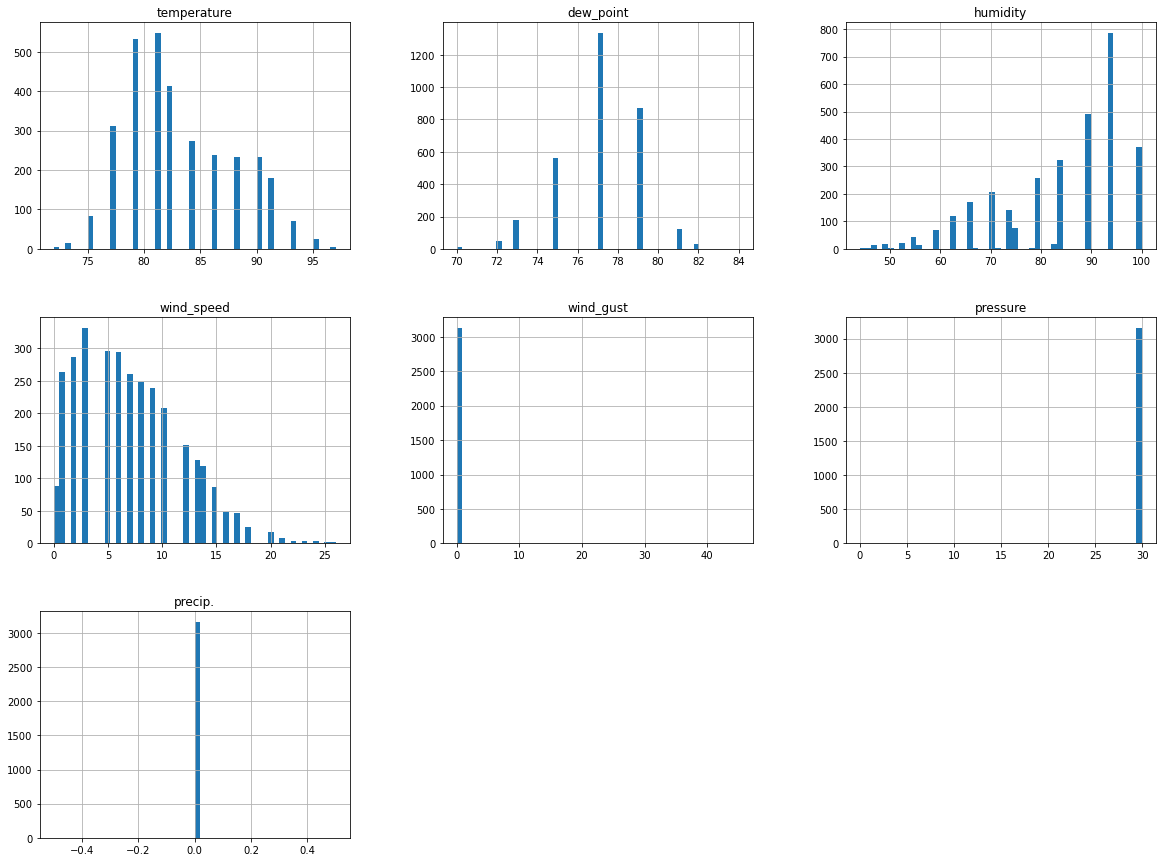

In [12]:
df[num_cols].hist(bins=50, figsize=(20, 15))
plt.show()

We have few observations:
* These attributes have very different scales.
* `precip` column is all $0$, so this attribute does not supply any information.
* Daa in `wind_gust` and `pressure` are weird, most of values are in the smaller certain range, so that we think there are outlier.

### How data distribute of each categorical column



In [6]:
pd.set_option('display.max_colwidth', 100) # Để dễ nhìn
pd.set_option('display.max_columns', None) # Để dễ nhìn
# YOUR CODE HERE

# print(type(cate_cols))
def CountUniqueValues(s):
    s = s.dropna().str.split(';').explode()
    return len(s.unique())
def CountFrequenciesSeries(s):
#     if s.name != 'MainBranch':
#         return None
#     print(type(s))
    s = s.dropna().str.split(';').explode()
    return (s.value_counts(normalize = True)*100).round(1).to_dict()

cate_col_info_df = pd.DataFrame(index=['missing_percentage', 'num_values', 'value_percentages'], columns=cate_cols)
cate_col_info_df.loc['missing_percentage'] = df[cate_cols].isnull().sum(axis = 0).divide(len(df) / 100).round(1)
cate_col_info_df.loc['num_values'] = df[cate_cols].apply(CountUniqueValues)
# cate_col_info_df.at['num_values', 'DevType'] = len(survey_df['DevType'].dropna().str.split(';').explode().unique())
cate_col_info_df.loc['value_percentages'] = df[cate_cols].apply(CountFrequenciesSeries)
# cate_col_info_df.at['value_percentages', 'MainBranch'] = survey_df[['MainBranch']].apply(CountFrequenciesSeries)
# raise NotImplementedError()
cate_col_info_df

,date,time,wind,condition
missing_percentage,0.0,0.0,0.0,0.0
num_values,66,48,18,20
value_percentages,"{'2021-08-27': 1.5, '2021-07-04': 1.5, '2021-08-05': 1.5, '2021-08-08': 1.5, '2021-07-24': 1.5, ...","{'11:00 PM': 2.1, '11:00 AM': 2.1, '6:30 AM': 2.1, '9:30 PM': 2.1, '4:30 AM': 2.1, '2:30 PM': 2....","{'WSW': 25.6, 'VAR': 20.5, 'W': 16.8, 'SW': 11.6, 'WNW': 4.3, 'S': 3.1, 'SSW': 3.1, 'CALM': 2.8,...","{'Partly Cloudy': 54.0, 'Mostly Cloudy': 28.5, 'Fair': 6.0, 'Light Rain': 4.8, 'Light Rain Showe..."


We visualize data for better looking

/home/dell/anaconda3/envs/min_ds-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


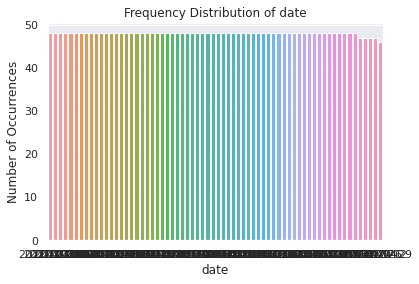

In [8]:
count = df['date'].value_counts()
sns.set(style="darkgrid")
sns.barplot(count.index, count.values, alpha=0.9)
plt.title('Frequency Distribution of date')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('date', fontsize=12)
plt.show()

/home/dell/anaconda3/envs/min_ds-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


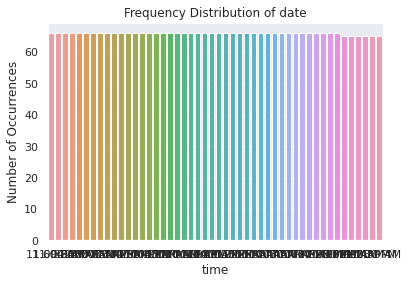

In [9]:
count = df['time'].value_counts()
sns.set(style="darkgrid")
sns.barplot(count.index, count.values, alpha=0.9)
plt.title('Frequency Distribution of date')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('time', fontsize=12)
plt.show()

/home/dell/anaconda3/envs/min_ds-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


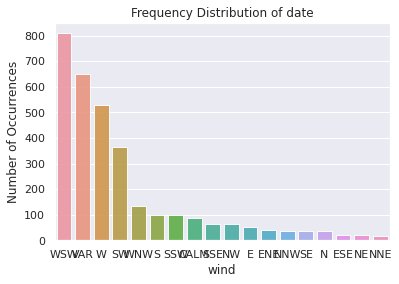

<Figure size 17280x8640 with 0 Axes>

In [18]:
count = df['wind'].value_counts()
sns.set(style="darkgrid")
sns.barplot(count.index, count.values, alpha=0.9)
plt.title('Frequency Distribution of date')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('wind', fontsize=12)
plt.figure(figsize=(240, 120))
plt.show()

/home/dell/anaconda3/envs/min_ds-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


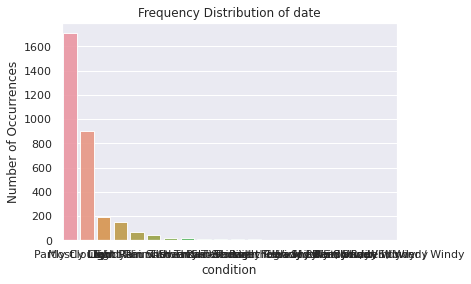

<Figure size 17280x8640 with 0 Axes>

In [19]:
count = df['condition'].value_counts()
sns.set(style="darkgrid")
sns.barplot(count.index, count.values, alpha=0.9)
plt.title('Frequency Distribution of date')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('condition', fontsize=12)
plt.figure(figsize=(240, 120))
plt.show()

We have some observations:
* Distribution of date and time is uniform.
* `wind` and `condition` have some values which frequency is low

## A question

We want to forecast the weather. Concretely, we will predict weather condition in the next thridty minutes base on the current weather information.

## Preprocess

What we are going to do:
* Preprocessing `condition` data
* Remove outlier from `

First, we have to preprocess `condition` column. Because we want to predict the future weather but it now shows the current condition. We relize that `date` and `time` likely are sorted, so that we need to check is it already arranged

In [22]:
def CheckDate(date_df):
    max_day = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    days=[0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    for i in range(1, len(days)):
        days[i] += days[i - 1]
    previous, pyear, pday, pmonth = None, None, None, None
    for index, value in date_df.items():
        ymd = value.split('-')
        year, month, day = int(ymd[0]), int(ymd[1]), int(ymd[2])
        now = (year-1) * 365 + days[month - 1] + day
        if index != 0:
            if now != previous:
                if month == 2 and days == 29:
                    if year % 4 != 0 or pyear != year or pmonth != month or pday != 28:
                        return False
                if month > 12 or day > max_day[month]:
                    return False
                if now - previous != 1:
                    return False
        previous, pyear, pmonth, pday = now, year, month, day
    return True

CheckDate(df['date'])

True

In [29]:
def CheckTime(time_df):
    previous, pdn = None, None
    for index, value in time_df.items():
        dn = value[-2:]
        hm = value[:-3].split(':')
        hour, minute = int(hm[0]) % 12, int(hm[1]) % 60
        now = hour * 60 + minute
        if index != 0:
            if dn == pdn:
                if now - previous != 30:
                    print(index)
                    return False
            else:
                if (hour + 12) * 60 + minute - previous != 30:
                    print(index)
                    return False
        previous, pdn = now, dn
    return True

CheckTime(df.time)

1247


False

In [15]:
condition_temp = df.condition.drop(index=[0], inplace = False)
# condition_temp.head(5)
condition_temp.reset_index(drop = True, inplace = True)
print(condition_temp.shape)
df.drop(index = df.shape[0] - 1, inplace = True)
df['condition'] = condition_temp
df['condition'].head(5)
# condition_temp.shape
# condition_temp.head(5)

(3161,)


0    Partly Cloudy
1             Fair
2             Fair
3             Fair
4             Fair
Name: condition, dtype: object

In [7]:
df['condition'].head(18)

0     Partly Cloudy
1              Fair
2              Fair
3              Fair
4              Fair
5              Fair
6              Fair
7              Fair
8              Fair
9              Fair
10             Fair
11             Fair
12             Fair
13             Fair
14             Fair
15             Fair
16    Partly Cloudy
17    Partly Cloudy
Name: condition, dtype: object

In [16]:
def CheckDateTime(time_df):
    ans = np.ones(time_df.shape[0])
    previous, pdn = None, None
    for index, value in time_df.items():
        dn = value[-2:]
        hm = value[:-3].split(':')
        hour, minute = int(hm[0]) % 12, int(hm[1]) % 60
        now = hour * 60 + minute
        if index != 0:
            if dn == pdn:
                if now - previous != 30:
#                     print(index)
                    ans[index] = 0
            else:
                if (hour + 12) * 60 + minute - previous != 30:
                    ans[index] = 0
        previous, pdn = now, dn
    return ans

ans = CheckDateTime(df['time'])
df.drop(np.where(ans==0)[0], axis=0, inplace=True)
df.reset_index(inplace=True)

Next, we preprocess `pressure` column

In [5]:
df['pressure'].value_counts()

29.73    681
29.76    640
29.70    606
29.67    417
29.79    337
29.64    224
29.82    105
29.85     65
29.61     63
29.88     13
29.91      2
0.00       1
29.58      1
Name: pressure, dtype: int64

We see that most of values are from $29.61$ to $29.91$, but there is a row which has $0$ value, therefore, we decide it is the outlier

In [17]:
df.drop(np.where(df['pressure']==0)[0], inplace = True)
df.shape

(3154, 12)

Finnal, we preprocess `wind_gust` column

In [42]:
df['wind_gust'].value_counts()

0     3126
31       4
32       3
36       3
22       2
24       2
20       2
37       2
35       1
43       1
41       1
39       1
29       1
33       1
44       1
40       1
30       1
45       1
Name: wind_gust, dtype: int64

We see that $0$ is dominated in this column, the other is very few, and we afraid of overfitting, therefore, we decide to remove this column.

In [11]:
df.drop(columns='index', inplace=True)
df.to_csv('data/Preprossing_data.csv', index=False)

In [10]:
df.columns

Index(['index', 'date', 'time', 'temperature', 'dew_point', 'humidity', 'wind',
       'wind_speed', 'wind_gust', 'pressure', 'precip.', 'condition'],
      dtype='object')

### What we will predict

In [18]:
df.condition.value_counts()

Partly Cloudy                1706
Mostly Cloudy                 899
Fair                          189
Light Rain                    150
Light Rain Shower              71
Light Rain with Thunder        42
T-Storm                        20
Thunder in the Vicinity        16
Rain Shower                     8
Heavy T-Storm                   8
Thunder                         7
Showers in the Vicinity         7
Partly Cloudy / Windy           6
Fog                             6
Light Rain Shower / Windy       5
Heavy Rain Shower               4
Heavy T-Storm / Windy           4
Heavy Rain Shower / Windy       2
Mostly Cloudy / Windy           2
Rain Shower / Windy             2
Name: condition, dtype: int64